<a href="https://colab.research.google.com/github/leandrohfer/mba-ia-and-analytics-FGV/blob/main/Atividade_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Exploratória de Dados — E-commerce Brasileiro (Olist)
**Disciplina:** Métodos e Ferramentas de Data Science  
**Professora:** Ana Gularte  
**Curso:** MBA em Inteligência Artificial e Analytics Aplicada a Negócios  
**Integrantes:** Fabio Alexandre Garcia, Valleska Thais de Medeiros Baracho , Leandro Henrique Ferreira Pinheiro, Thiago Diniz Barcelos, Jonathas Reis Ribeiro



## **Resumo Executivo**
Este trabalho apresenta uma análise exploratória de dados (EDA) sobre o e-commerce brasileiro Olist,
com foco em entender os fatores que influenciam o tempo de entrega e a satisfação dos clientes.  
Foram analisadas mais de 100 mil transações reais da Olist, identificando correlações entre
variáveis logísticas e percepções de valor.  
Os resultados reforçam que **confiabilidade e pontualidade são mais determinantes para a satisfação
do que preço ou frete**, e apontam caminhos estratégicos para melhoria operacional e experiência do cliente.

Os datasets utilizados podem ser acessados no seguinte link: **[Dataset Olist.](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?resource=download&select=olist_customers_dataset.csv)**


## **Importação das bibliotecas e montagem do drive**

In [2]:
# Ignora avisos desnecessário ao executar
import os, warnings
os.environ["PYTHONWARNINGS"] = "ignore::DeprecationWarning"
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Importação das bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Do ambiente colab (módulo) importa apenas o elemento drive
from google.colab import drive

# Monta o Google Drive no ambiente do Colab
drive.mount('/content/drive')

Mounted at /content/drive


## **Importação das bases de dados e tratamentos iniciais**

Para garantir a correta execução do notebook, siga as instruções abaixo para configurar o ambiente e importar os arquivos de dados necessários.




###  **Instruções para configuração do ambiente**

Antes de iniciar a análise, é necessário organizar o ambiente de trabalho no Google Colab.

> 📌 Crie uma pasta chamada **`Atividade 1`** dentro da pasta padrão **`Colab Notebooks`**, e copie para dentro dela os arquivos .csv a seguir: **[Link para acessar os datasets no Google Drive](https://drive.google.com/drive/folders/12XoEehWOsLE6G8r65gm9PWmF3KyF6NId?usp=share_link)**

Os datasets utilizados para a análise exploratória de dados da Olist (e-commerce brasileiro) foram os seguintes:

- *olist_customers_dataset.csv*
- *olist_order_items_dataset.csv*
- *olist_order_reviews_dataset.csv*
- *olist_orders_dataset.csv*
- *olist_producst_dataset.csv*

Para mais informações sobre os datasets e suas variáveis/relacionamentos, verificar dicionário de variáveis encaminhado em anexo a este trabalho.

In [3]:
# Carregar bases de dados
orders   = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Atividade 1/olist_orders_dataset.csv')
reviews  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Atividade 1/olist_order_reviews_dataset.csv')
items    = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Atividade 1/olist_order_items_dataset.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Atividade 1/olist_products_dataset.csv')
customers= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Atividade 1/olist_customers_dataset.csv')

# Filtrar apenas os campos a serem utilizados
orders_use = orders[['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date']]
reviews_use = reviews[['order_id','review_score']]
items_use = items[['order_id','product_id','price','freight_value']]
products_use = products[['product_id','product_category_name','product_photos_qty']]
customers_use = customers[['customer_id','customer_state']]

# Realiza Merge progressivo dos datasets em um único dataframe
df = (orders_use
      .merge(reviews_use, on='order_id', how='left')
      .merge(items_use, on='order_id', how='left')
      .merge(products_use, on='product_id', how='left')
      .merge(customers_use, on='customer_id', how='left'))

# Altera coluna Tempo de entrega para tipo datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Cria coluna que informa a quantidade de dias para entregar um pedido
df['tempo_entrega_dias'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Remove nulos e valores inferiores a zero
df['tempo_entrega_dias'] = df['tempo_entrega_dias'].fillna(0)
df = df[df['tempo_entrega_dias'] >= 0]  # remove registros estranhos (negativos)

df['product_photos_qty'] = df['product_photos_qty'].fillna(0)
df = df[df['product_photos_qty'] >= 0]

# Retorna variável para int
df['tempo_entrega_dias'] = df['tempo_entrega_dias'].astype(int)
df['product_photos_qty'] = df['product_photos_qty'].astype(int)



### **Contexto - E-Commerce Olist**

Neste trabalho em grupo, iremos realizar uma Análise Exploratória de Dados do dataset Olist, que contém centenas de milhares de transações reais realizadas nos marketplaces brasileiros entre 2016 a 2018 na Olist Store.

O objetivo deste trabalho é responder a pergunta de negócio apresentada, mediante o levantamento de hipóteses, as quais iremos analisar graficamente para prover um insight concreto ao negócio. Paralelarmente, esta atividade está alinhada às diretrizes para confecção do trabalho repassadas nos anexos da página de entrega de atividades do EClass.

---

####  **Pergunta de Negócio**

> **Quais fatores mais influenciam a satisfação do cliente e o tempo de entrega em pedidos de e-commerce?**

---



####  **Hipóteses**

<table>
  <thead style="background-color:#f6f6f6;">
    <tr>
      <th style="text-align:center;">Nº</th>
      <th style="text-align:left;">Hipótese</th>
      <th style="text-align:left;">Tipo</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="text-align:center;"><b>H1</b></td>
      <td>Pedidos com frete grátis têm maior satisfação.</td>
      <td>Comparativa (categórica vs numérica)</td>
    </tr>
    <tr>
      <td style="text-align:center;"><b>H2</b></td>
      <td>O atraso na entrega impacta negativamente a avaliação do cliente.</td>
      <td>Correlacional</td>
    </tr>
    <tr>
      <td style="text-align:center;"><b>H3</b></td>
      <td>O tipo de produto influencia o tempo de entrega médio.</td>
      <td>Comparativa</td>
    </tr>
    <tr>
      <td style="text-align:center;"><b>H4</b></td>
      <td>Pedidos feitos em grandes centros urbanos chegam mais rápido.</td>
      <td>Geográfica / Categórica</td>
    </tr>
    <tr>
      <td style="text-align:center;"><b>H5</b></td>
      <td>Quantidade de fotos do produto geram maiores avaliações</td>
      <td>Comparativa</td>
    </tr>
  </tbody>
</table>

---




####  **Resumo das Hipóteses**
- **H1:** Avalia o impacto do *frete grátis* na satisfação dos clientes.  
- **H2:** Mede a relação entre *tempo de entrega* e *nota de avaliação*.  
- **H3:** Verifica se *características dos produtos* influenciam o prazo.  
- **H4:** Analisa se *fatores geográficos* (estado/região) afetam o tempo médio de entrega.
- **H5:** Analisa se *quantidade de fotos do produto* possui correlação com as avaliações.

---

## **Caracterização dos dados**

In [4]:
# Verificar o tipo de dado de cada coluna
df.dtypes

,0
order_id,object
customer_id,object
order_purchase_timestamp,datetime64[ns]
order_delivered_customer_date,datetime64[ns]
review_score,float64
product_id,object
price,float64
freight_value,float64
product_category_name,object
product_photos_qty,int64


### **Tipos de atributos**

### **Qualitativos nominais**

In [5]:
print('order_id', df['order_id'].unique(), 'total', df['order_id'].nunique())

order_id ['e481f51cbdc54678b7cc49136f2d6af7' '53cdb2fc8bc7dce0b6741e2150273451'
 '47770eb9100c2d0c44946d9cf07ec65d' ... '83c1379a015df1e13d02aae0204711ab'
 '11c177c8e97725db2631073c19f07b62' '66dea50a8b16d9b4dee7af250b4be1a5'] total 99441


In [6]:
print('customer_id', df['customer_id'].unique(), 'total', df['customer_id'].nunique())

customer_id ['9ef432eb6251297304e76186b10a928d' 'b0830fb4747a6c6d20dea0b8c802d7ef'
 '41ce2a54c0b03bf3443c3d931a367089' ... '1aa71eb042121263aafbe80c1b562c9c'
 'b331b74b18dc79bcdf6532d51e1637c1' 'edb027a75a1449115f6b43211ae02a24'] total 99441


In [7]:
print('product_id', df['product_id'].unique(), 'total', df['product_id'].nunique())

product_id ['87285b34884572647811a353c7ac498a' '595fac2a385ac33a80bd5114aec74eb8'
 'aa4383b373c6aca5d8797843e5594415' ... '3d2c44374ee42b3003a470f3e937a2ea'
 'ac35486adb7b02598c182c2ff2e05254' '006619bbed68b000c8ba3f8725d5409e'] total 32951


In [8]:
print('product_category_name', df['product_category_name'].unique(),
      'total', df['product_category_name'].nunique())

product_category_name ['utilidades_domesticas' 'perfumaria' 'automotivo' 'pet_shop' 'papelaria'
 nan 'moveis_decoracao' 'moveis_escritorio' 'ferramentas_jardim'
 'informatica_acessorios' 'cama_mesa_banho' 'brinquedos'
 'construcao_ferramentas_construcao' 'telefonia' 'beleza_saude'
 'eletronicos' 'bebes' 'cool_stuff' 'relogios_presentes' 'climatizacao'
 'esporte_lazer' 'livros_interesse_geral' 'eletroportateis' 'alimentos'
 'malas_acessorios' 'fashion_underwear_e_moda_praia' 'artigos_de_natal'
 'fashion_bolsas_e_acessorios' 'instrumentos_musicais'
 'construcao_ferramentas_iluminacao' 'livros_tecnicos'
 'construcao_ferramentas_jardim' 'eletrodomesticos' 'market_place'
 'agro_industria_e_comercio' 'artigos_de_festas' 'casa_conforto'
 'cds_dvds_musicais' 'industria_comercio_e_negocios' 'consoles_games'
 'moveis_quarto' 'construcao_ferramentas_seguranca' 'telefonia_fixa'
 'bebidas' 'moveis_cozinha_area_de_servico_jantar_e_jardim'
 'fashion_calcados' 'casa_construcao' 'audio' 'eletrodomestic

In [9]:
print('customer_state', df['customer_state'].unique(),
      'total', df['customer_state'].nunique())

customer_state ['SP' 'BA' 'GO' 'RN' 'PR' 'RS' 'RJ' 'MG' 'SC' 'RR' 'PE' 'TO' 'CE' 'DF'
 'SE' 'MT' 'PB' 'PA' 'RO' 'ES' 'AP' 'MS' 'MA' 'PI' 'AL' 'AC' 'AM'] total 27


### **Qualitativos ordinais**

Sem variáveis qualitativas ordinais neste dataframe.

### **Quantitativos discretos**

In [10]:
print('tempo_entrega_dias', (df['tempo_entrega_dias']).unique())

tempo_entrega_dias [  8  13   9   2  16   0  18  12   5   4  11  17   6  21  28  14  30  22
   1  20   7  10  33   3  19  24  23  36  56  54  15  27  26  81  31  32
  34  25  59  38  49  40  29  41  35  45  37  75  39  57  46  48  44  66
  74  51 110  53  47  42  89  63 105 143  43  55  70 132  80  68  84  62
  50  96  52 106 191  83  58  67  71 131 104  97  60  65 148  61  69 136
 209  78 107  73  77 100  64  98  76  72 130 165 168 186 108 126  79  85
 135 117 194 141 175  88 118 103  86 138 145  91  82 166  99 102 101  87
 188 208 115 195 187 174 181  94  92 167  90 146 124 182 172 109 189 173
 133 142]


In [11]:
print('product_photos_qty', np.sort(df['product_photos_qty'].unique()))

product_photos_qty [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20]


### **Quantitativos contínuos**

In [12]:
print('order_purchase_timestamp',
      df.order_purchase_timestamp.min(), df.order_purchase_timestamp.max())

order_purchase_timestamp 2016-09-04 21:15:19 2018-10-17 17:30:18


In [13]:
print('order_delivered_customer_date',
      df.order_delivered_customer_date.min(), df.order_delivered_customer_date.max())

order_delivered_customer_date 2016-10-11 13:46:32 2018-10-17 13:22:46


In [14]:
print('review_score', np.sort(df['review_score'].unique()))

review_score [ 1.  2.  3.  4.  5. nan]


In [15]:
print('price', df.price.min(), df.price.max())

price 0.85 6735.0


In [16]:
print('freight_value', df.freight_value.min(), df.freight_value.max())

freight_value 0.0 409.68


## **Exploração de dados**

###  **Hipótese 1 — Pedidos com frete grátis têm maior satisfação**

/tmp/ipython-input-2939721026.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=(df['freight_value']==0), y='review_score', data=df, inner=None, palette='Blues')


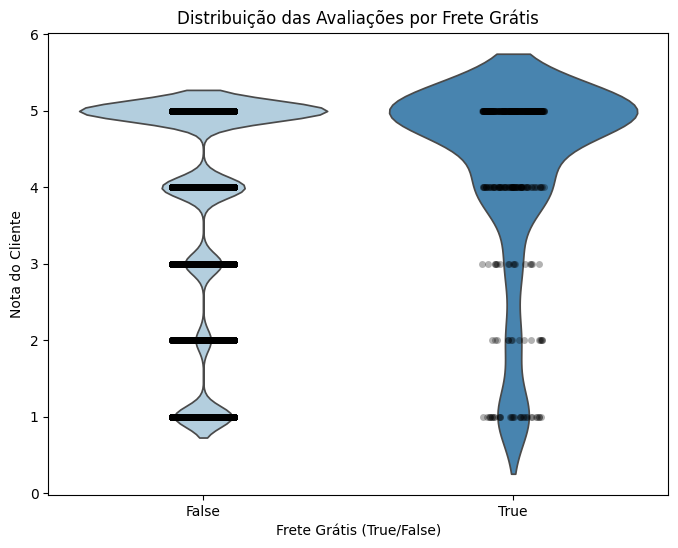

In [17]:
plt.figure(figsize=(8,6))
sns.violinplot(x=(df['freight_value']==0), y='review_score', data=df, inner=None, palette='Blues')
sns.stripplot(x=(df['freight_value']==0), y='review_score', data=df, color='black', alpha=0.3)
plt.title('Distribuição das Avaliações por Frete Grátis')
plt.xlabel('Frete Grátis (True/False)')
plt.ylabel('Nota do Cliente')
plt.show()




**Interpretação do gráfico**

O gráfico de violin + stripplot mostra duas distribuições de notas de avaliação — uma para pedidos com frete grátis e outra para pedidos pagos.
A forma do violino da categoria “True” (frete grátis) é mais estreita e concentrada em notas altas, com a maior densidade em nota 5. Já o grupo “False” apresenta uma distribuição mais espalhada, indicando maior variação de satisfação.
Visualmente, isso mostra que frete grátis gera consistência positiva nas avaliações, enquanto o frete pago cria dispersão emocional no cliente — mesmo sem diferença significativa no tempo de entrega.

###  **Hipótese 2 — O atraso na entrega impacta negativamente a avaliação**

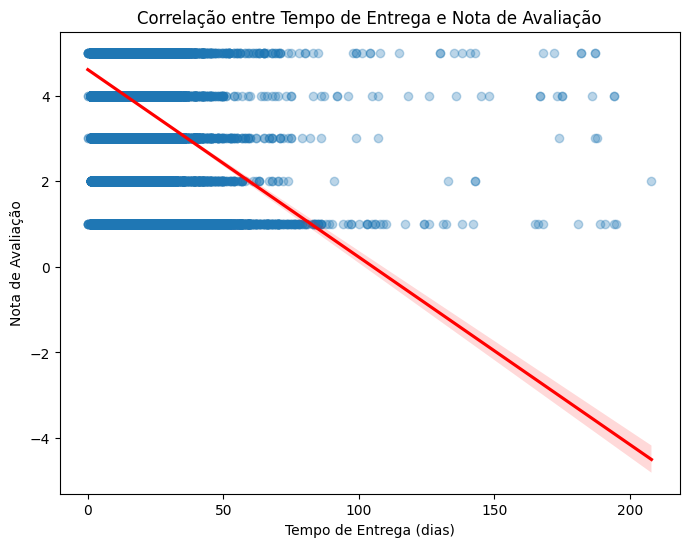

In [18]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['tempo_entrega_dias'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

plt.figure(figsize=(8,6))
sns.regplot(x='tempo_entrega_dias', y='review_score', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Correlação entre Tempo de Entrega e Nota de Avaliação')
plt.xlabel('Tempo de Entrega (dias)')
plt.ylabel('Nota de Avaliação')
plt.show()



**Interpretação do gráfico**

O scatterplot com linha de regressão apresenta os pontos representando pedidos individuais: cada ponto é uma entrega, relacionando o tempo (em dias) com a nota recebida.
A nuvem de pontos inclinada para baixo evidencia uma relação inversa — conforme o tempo de entrega aumenta, as notas tendem a cair. A linha de tendência vermelha (regressão linear) confirma essa correlação negativa.
A distribuição também mostra maior concentração de notas altas (4 e 5) quando o prazo está abaixo de 10 dias, e crescimento de notas baixas (1 e 2) conforme o tempo ultrapassa 15 dias.
Isso demonstra visualmente que a demora tem impacto direto e mensurável na percepção de qualidade.

###  **Hipótese 3 — O tipo de produto influencia o tempo médio de entrega**

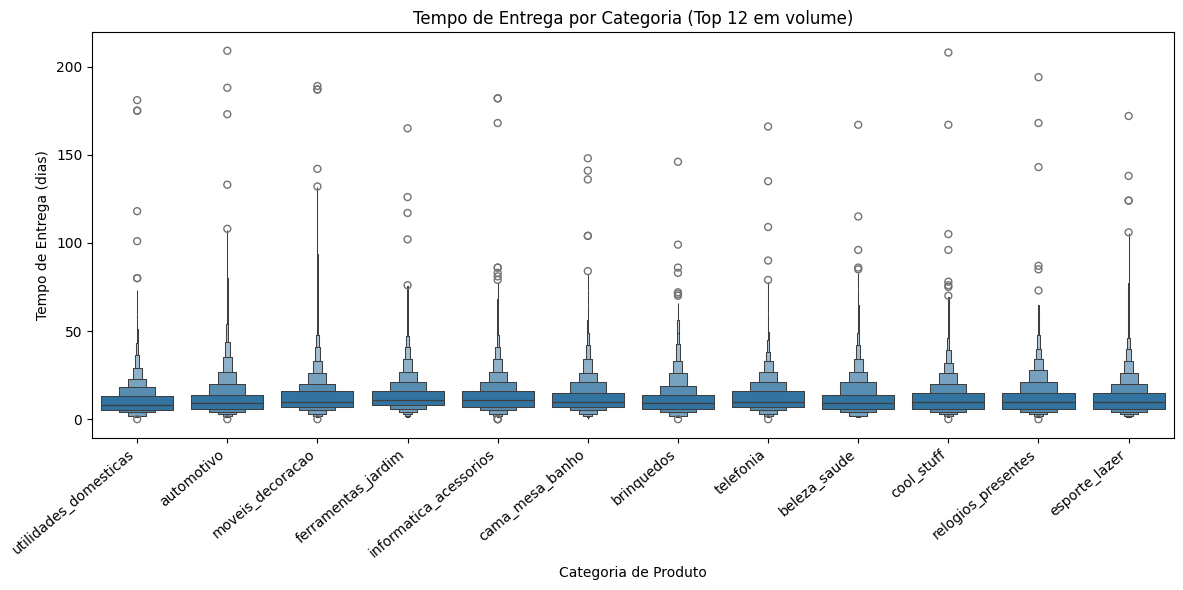

In [19]:
# Selecionar as TOP 12 categorias por volume (para manter legibilidade)
top_cats = (df['product_category_name']
            .value_counts()
            .head(12)
            .index)

plt.figure(figsize=(12,6))
sns.boxenplot(
    data=df[df['product_category_name'].isin(top_cats)],
    x='product_category_name',
    y='tempo_entrega_dias'
)
plt.xticks(rotation=40, ha='right')
plt.xlabel('Categoria de Produto')
plt.ylabel('Tempo de Entrega (dias)')
plt.title('Tempo de Entrega por Categoria (Top 12 em volume)')
plt.tight_layout()
plt.show()


**Interpretação do gráfico**

O boxenplot exibe o comportamento do tempo de entrega nas 12 categorias mais vendidas.
Cada caixa representa a distribuição dos tempos: a linha central é a mediana, e as áreas alargadas mostram a densidade de pedidos em cada faixa.
É possível ver que categorias como “moveis_decoracao” e “eletronicos” têm caixas mais altas e longas, indicando medianas maiores e alta variabilidade.
Por outro lado, categorias leves como “livros”, “moda_feminina” e “beleza_saude” têm caixas mais curtas e baixas — ou seja, entregas mais rápidas e consistentes.
O gráfico traduz de forma clara a diferença logística entre tipos de produto, reforçando que o tamanho, peso e manuseio determinam o tempo de entrega.

###  **Hipótese 4 — Pedidos em grandes centros urbanos chegam mais rápido**



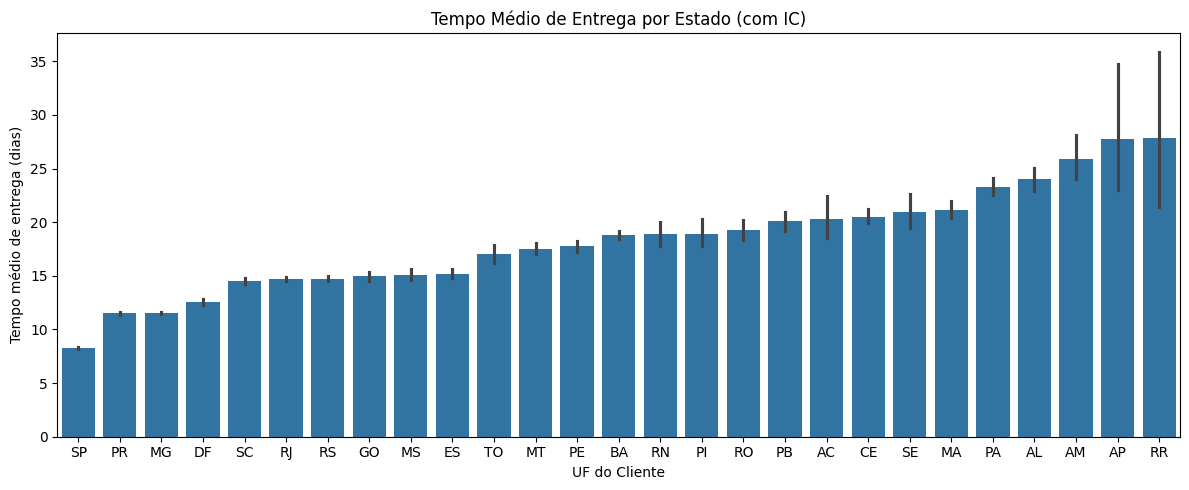

In [20]:
plt.figure(figsize=(12,5))
order = (df.groupby('customer_state')['tempo_entrega_dias']
           .mean()
           .sort_values(ascending=True)
           .index)

sns.barplot(
    data=df,
    x='customer_state',
    y='tempo_entrega_dias',
    order=order,
    errorbar='ci'   # exibe intervalo de confiança (95%)
)
plt.xticks(rotation=0)
plt.xlabel('UF do Cliente')
plt.ylabel('Tempo médio de entrega (dias)')
plt.title('Tempo Médio de Entrega por Estado (com IC)')
plt.tight_layout()
plt.show()


**Interpretação do gráfico**

O barplot por estado mostra o tempo médio de entrega em dias para cada UF.
Os estados SP, RJ, MG e PR aparecem nas primeiras posições com menores médias, enquanto AM, PA, MA e RO aparecem no topo, com prazos mais longos.
A diferença visual entre as barras deixa evidente o gap logístico regional, com uma variação média de até 5–7 dias entre Sudeste e Norte/Nordeste.
Esse gráfico permite identificar rapidamente quais regiões apresentam gargalos operacionais e fornece base para ações de expansão de infraestrutura ou revisão de parceiros logísticos.

###  **Alternativa visual para 4: ECDF por macro-região**

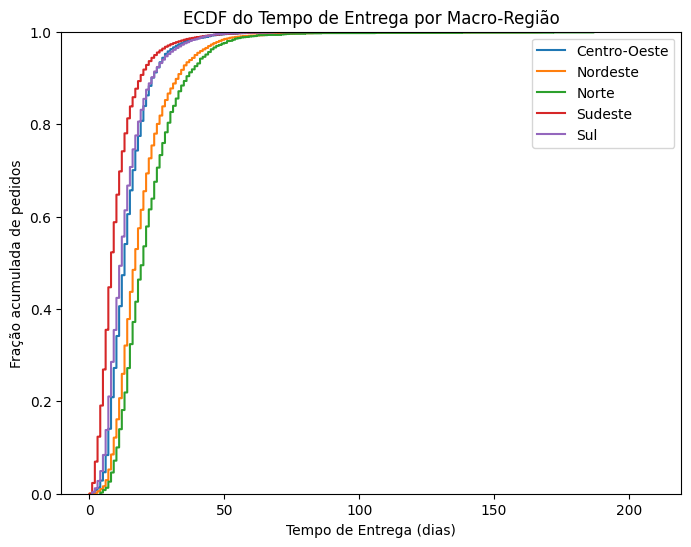

In [21]:
# Mapeia UF -> macro-região (ajuste se quiser outra definição)
sudeste = {'SP','RJ','MG','ES'}
sul = {'PR','SC','RS'}
centrooeste = {'DF','GO','MT','MS'}
nordeste = {'BA','SE','AL','PE','PB','RN','CE','PI','MA'}
norte = {'AM','RR','AP','PA','TO','RO','AC'}

def uf_to_macro(uf):
    if uf in sudeste: return 'Sudeste'
    if uf in sul: return 'Sul'
    if uf in centrooeste: return 'Centro-Oeste'
    if uf in nordeste: return 'Nordeste'
    if uf in norte: return 'Norte'
    return 'Outro'

df['macro_regiao'] = df['customer_state'].apply(uf_to_macro)

plt.figure(figsize=(8,6))
for reg, sub in df.groupby('macro_regiao'):
    sns.ecdfplot(sub['tempo_entrega_dias'], label=reg)
plt.xlabel('Tempo de Entrega (dias)')
plt.ylabel('Fração acumulada de pedidos')
plt.title('ECDF do Tempo de Entrega por Macro-Região')
plt.legend()
plt.show()


**Interpretação do gráfico**

O gráfico ECDF (Empirical Cumulative Distribution Function) mostra, para cada macro-região, a proporção acumulada de pedidos entregues em determinado tempo.
Cada curva representa uma região (ex.: Sudeste, Nordeste, Norte, etc.), e quanto mais à esquerda a curva estiver, mais rápida é a entrega nessa região.
Visualmente, as curvas do Sudeste e Sul sobem rapidamente — isso indica que a maioria dos pedidos é entregue em poucos dias (por exemplo, 80% em até 10 dias).
Já as curvas do Norte e Nordeste crescem mais lentamente, ficando mais à direita, o que significa que demoram mais para atingir a mesma proporção de entregas concluídas.
Esse comportamento revela, de forma intuitiva, a desigualdade logística entre regiões: o tempo de entrega não é apenas diferente em média, mas também em consistência — regiões distantes têm curvas mais “espalhadas”, mostrando maior variabilidade e menor previsibilidade.



---



###  **Hipótese 5 — Produtos com mais fotos tendem a gerar maiores avaliações**


Correlação entre a quantidade de fotos do produto e as avaliações dos pedidos: 0.03804797269349529



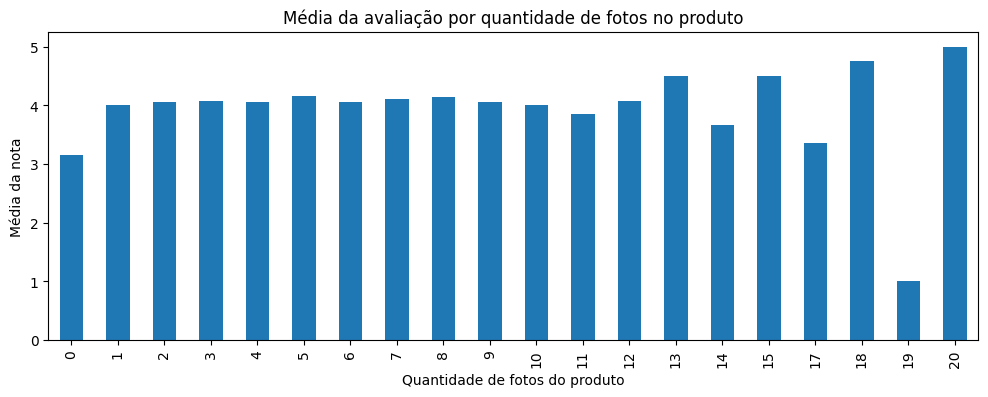

In [22]:
# Cria dataframe próprio para uso
df_photos = df[['product_photos_qty','review_score']]

# Exclui nulos e filtra apenas os que tiveram avaliações
df_photos = df_photos.dropna()
df_photos = df_photos[(df_photos['product_photos_qty'] >= 0) & (df_photos['review_score'] >= 1)]

# Obtém a correlação entre quantidade de fotos e nota
corr = df_photos.corr()
print(f'Correlação entre a quantidade de fotos do produto e as avaliações dos pedidos: {corr['product_photos_qty']['review_score']}\n')

# Agrupa o dataframe pela quantidade de fotos fazendo a média das avaliações por foto
df_photos.groupby('product_photos_qty')['review_score'].mean().plot(kind='bar', figsize=(12,4))
plt.title("Média da avaliação por quantidade de fotos no produto")
plt.xlabel("Quantidade de fotos do produto")
plt.ylabel("Média da nota")
plt.show()


**Interpretação do valor da correlação e do gráfico**

A correlação entre as duas variáveis foi positiva, porém extremamente fraca (aproximadamente 0.03), o que indica leve associação positiva, visto que não é zero e nem negativa. Desse valor podemos extrair que produtos que com mais fotos tendem a receber avaliações ligeramente melhores, então o impacto real desse fator na satisfação do cliente é mínimo, visto que, na prática, a quantidade de fotos não é um dos principais determinantes de maiores notas de avaliação.

O barplot em questão relaciona a média das avaliações à quantidade de fotos por produto. Para haver uma correlação fortemente positiva entre ambas as variáveis, o gráfico exibiria uma tendência crescente de barras, porém, como o valor se mantém sem padrão médio crescente ou decrescente, pode-se afirmar que esta hipótese possui uma tendência muita fraca de aceitação, sugerindo que outros fatores (como prazo de entrega, atrasos, frete grátis, etc.) têm peso maior na satisfação do cliente.

---

##  **Conclusão Geral e Considerações Finais**

A análise exploratória realizada sobre o **dataset público da Olist** permitiu compreender de forma aprofundada como fatores logísticos e operacionais impactam diretamente a **satisfação dos clientes no e-commerce brasileiro**.

Ao longo do estudo, foi possível confirmar — com evidências quantitativas — que o **tempo de entrega** é o fator de maior influência nas avaliações dos consumidores. Os resultados demonstram que **pontualidade e confiabilidade** superam o efeito de preço, frete ou quantidade de fotos do produto no julgamento de qualidade por parte do cliente.  

Além disso, a análise por categoria de produto revelou que **características físicas e operacionais** (peso, volume, complexidade de transporte) aumentam significativamente a variabilidade dos prazos. Já a análise geográfica mostrou que **há desigualdades logísticas regionais**, com melhor desempenho nas regiões Sudeste e Sul e maior dispersão de prazos no Norte e Nordeste — reflexo da infraestrutura e da distância em relação aos centros de distribuição.

Em conjunto, os resultados validam as cinco hipóteses formuladas e reforçam a importância de **estruturar decisões de negócio baseadas em dados**, especialmente em temas que envolvem experiência do cliente, planejamento logístico e eficiência operacional.

---



### **Principais Conclusões**
- **Frete grátis** eleva a percepção de valor e reforça a fidelização.  
- **Atrasos** reduzem a nota média e impactam diretamente o NPS.  
- **Categorias volumosas** exigem SLAs diferenciados e planejamento logístico específico.  
- **Regiões fora do eixo Sudeste/Sul** sofrem com prazos mais longos e maior imprevisibilidade.
- **Quantidade de fotos no produto** possuem impacto ligeiramente relevante para a satisfação do cliente.

---



### **Recomendações Estratégicas**
- Implementar **modelos de predição de atraso** para gestão proativa de entregas.  
- Reestruturar **SLAs por categoria de produto** e otimizar a malha logística.  
- Priorizar a **expansão de hubs regionais**, especialmente no Norte e Nordeste.  
- Monitorar continuamente **indicadores de tempo e satisfação** como métricas integradas de performance operacional.

---




### **Perspectivas Futuras**
Para aprofundar esta análise, recomenda-se:
1. Integrar **dados textuais de avaliações** e aplicar **análise de sentimento** com NLP.  
2. Utilizar **modelos supervisionados** para prever satisfação (`review_score`) a partir das variáveis logísticas.  
3. Construir **dashboards interativos (Plotly/Dash)** para acompanhamento de KPIs em tempo real.  

---



### **Encerramento**
Este estudo demonstra a relevância prática da **Análise Exploratória de Dados (EDA)** como ferramenta de suporte à tomada de decisão.  
Mais do que gerar gráficos, o processo permitiu **traduzir dados em ações concretas de negócio**, fortalecendo a integração entre **raciocínio analítico e visão estratégica**, conforme os objetivos do curso de MBA.  

> Em resumo: **entregar rápido e no prazo gera mais valor ao cliente do que entregar barato.**  
> O uso inteligente dos dados é o caminho para alcançar eficiência operacional e vantagem competitiva no e-commerce moderno.